In [1]:
# This script imports the NTSB training and validation sets,
# and iteratively tests the performance of various regression-based learners
# while grid searching over a range of hyperparameters for each, comparing
# the performance of all learners to each other and to a naive prediction
# which takes the mean value of each proprtion. After establishing the 
# best performing learner, feature importances are printed and the 
# model is applied to the test dataset.

# Load Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor



In [2]:

# Read in data, prepare for evaluation
## NOTE: The train/validation split has already been conducted at an earlier stage.

train = pd.read_csv('../data/ntsb_processed/ntsb_train_cleaned.csv').dropna()
validation = pd.read_csv('../data/ntsb_processed/ntsb_val_cleaned.csv').dropna()


In [3]:

target_f   = ['acft_prop_inj_f']
target_s   = ['acft_prop_inj_s']
features = ['latitude','longitude','apt_dist','gust_kts','aircraft_count',
            'num_eng','days_since_insp','light_cond_DAYL','light_cond_DUSK','light_cond_NDRK',
            'light_cond_NITE','light_cond_other/unknown','BroadPhaseofFlight_Air',
            'BroadPhaseofFlight_Ground','BroadPhaseofFlight_Landing','BroadPhaseofFlight_Takeoff',
            'BroadPhaseofFlight_other/unknown','eng_type_REC','eng_type_TF','eng_type_TP','eng_type_TS',
            'eng_type_other/unknown','far_part_091','far_part_121','far_part_135','far_part_137','far_part_PUBU',
            'far_part_other/unknown','acft_make_beech','acft_make_bell','acft_make_boeing','acft_make_cessna',
            'acft_make_mooney','acft_make_other/unknown','acft_make_piper','acft_make_robinson helicopter',
            'acft_category_AIR','acft_category_HELI','acft_category_other/unknown','homebuilt_N','homebuilt_Y',
            'fixed_retractable_FIXD','fixed_retractable_RETR',
            'second_pilot_N','second_pilot_Y','second_pilot_other/unknown']

X_train = train[features]
y_train_f = np.ravel(train[target_f])
y_train_s = np.ravel(train[target_s])

X_val = validation[features]
y_val_f = np.ravel(validation[target_f])
y_val_s = np.ravel(validation[target_s])



In [4]:
# Initialize performance dataframe
performances = pd.DataFrame(columns=['learner','hyperparams','target',
                                     'train_mse','train_mae','val_mse','val_mae'])

# Initialize Grid Search & Performance Append Function
def fatal_grid_search(model, param_grid, label):
    "Iteratively runs grid search on specified parameter grid and appends performance info to master dataset."
    
    target='prop_inj_fatal' # Declares label for target variable in master dataset

    grid = GridSearchCV(
        model,
        param_grid,
        scoring='neg_mean_squared_error',
        cv=5
    )
    grid.fit(X_train,y_train_f)
    best_mod = grid.best_estimator_
    best_params = grid.best_params_

    # Train and validation prediction objects 
    y_train_pred = best_mod.predict(X_train)
    y_val_pred = best_mod.predict(X_val)

    # Performance metrics
    train_mse = mean_squared_error(y_train_f,y_train_pred)
    val_mse = mean_squared_error(y_val_f,y_val_pred)
    train_mae = mean_absolute_error(y_train_f, y_train_pred)
    val_mae = mean_absolute_error(y_val_f, y_val_pred)

    # Append to performance dataframe
    performances.loc[len(performances)] = [
        label,
        str(best_params),
        target,
        train_mse,
        train_mae,
        val_mse,
        val_mae
    ]
    
    return best_mod


In [5]:

############################################################
##             Modeling: FATAL INJURIES                   ##
############################################################
# Run iterative grid searches of hyperparameter values per model
# Save best performing model & its metrics

## Random Forest Regressor Grid Search
rf = RandomForestRegressor()
rf_param_grid = {
    'n_estimators':[10],
    'min_samples_leaf':[2],
    'max_samples':[100]
}
rf_mod_f = fatal_grid_search(rf,rf_param_grid,"randomforest")



In [6]:

## Histogram Gradient Boosting Regressor Search
histgrad = HistGradientBoostingRegressor()
hg_param_grid = {
    'learning_rate': [0.05,0.1],
    'max_iter': [100],
    'max_leaf_nodes': [3]
}
hg_mod_f = fatal_grid_search(histgrad, hg_param_grid, "histgrad")



## Extra Trees Regressor
extrees = ExtraTreesRegressor()
et_param_grid = {
    'max_depth': [2],
    'n_estimators': [10],
    'max_leaf_nodes': [3]
}
et_mod_f = fatal_grid_search(extrees,et_param_grid,"extrees")



## Bagging Regressor
baggingreg = BaggingRegressor()
bg_param_grid = {
    'n_estimators': [10],
}
bag_mod_f = fatal_grid_search(baggingreg,bg_param_grid,"bagging")


## XGBoost
xgb = XGBRegressor()
xgb_param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.1],
    'subsample': [0.6],
    'colsample_bytree': [0.6]
}
xgb_mod_f = fatal_grid_search(xgb,xgb_param_grid,"xgboost")

## "Naive" Prediction - Average Proportion of Fatal Injuries
naive_train_pred = [y_train_f.mean()] * len(y_train_f)
naive_val_pred = [y_train_f.mean()] * len(y_val_f)

train_mse = mean_squared_error(y_train_f,naive_train_pred)
val_mse = mean_squared_error(y_val_f, naive_val_pred)
train_mae = mean_absolute_error(y_train_f, naive_train_pred)
val_mae = mean_absolute_error(y_val_f, naive_val_pred)

performances.loc[len(performances)] = [
        'naivemean', '{n/a}', 'prop_inj_fatal',
        train_mse, train_mae,
        val_mse, val_mae]



In [7]:

############################################################
# Initializing Serious Accidents Grid Search Function      #
############################################################


# Initialize Grid Search & Performance Append Function
def serious_grid_search(model, param_grid, label):
    "Iteratively runs grid search on specified parameter grid and appends performance info to master dataset."
    
    target='prop_inj_serious' # Declares label for target variable in master dataset

    grid = GridSearchCV(
        model,
        param_grid,
        scoring='neg_mean_squared_error',
        cv=5
    )
    grid.fit(X_train,y_train_s)
    best_mod = grid.best_estimator_
    best_params = grid.best_params_

    # Train and validation prediction objects 
    y_train_pred = best_mod.predict(X_train)
    y_val_pred = best_mod.predict(X_val)

    # Performance metrics
    train_mse = mean_squared_error(y_train_s,y_train_pred)
    val_mse = mean_squared_error(y_val_s,y_val_pred)
    train_mae = mean_absolute_error(y_train_s, y_train_pred)
    val_mae = mean_absolute_error(y_val_s, y_val_pred)

    # Append to performance dataframe
    performances.loc[len(performances)] = [
        label,
        str(best_params),
        target,
        train_mse,
        train_mae,
        val_mse,
        val_mae
    ]
    
    return best_mod



############################################################
##             Modeling: SERIOUS INJURIES                 ##
############################################################
# Run iterative grid searches of hyperparameter values per model
# Save best performing model & its metrics
# Since most objects for this script were created in previous section, all that must be done is to 
# run the new function on the same grid search & learner objects.

## Random Forest Regressor Grid Search
rf_mod_s = serious_grid_search(rf,rf_param_grid,"randomforest")

## Histogram Gradient Boosting Regressor Search
hg_mod_s = serious_grid_search(histgrad, hg_param_grid, "histgrad")

## Extra Trees Regressor
et_mod_s = serious_grid_search(extrees,et_param_grid,"extrees")

## Bagging Regressor
bag_mod_s = serious_grid_search(baggingreg,bg_param_grid,"bagging")

## XGBoost Regressor
xgb_mod_s = serious_grid_search(xgb,xgb_param_grid,"xgboost")

## "Naive" Prediction - Average Proportion of Serious Injuries
naive_train_pred = y_train_s.mean()
naive_val_pred = y_val_s.mean()

## "Naive" Prediction - Average Proportion of Serious Injuries
naive_train_pred = [y_train_s.mean()] * len(y_train_s)
naive_val_pred = [y_train_s.mean()] * len(y_val_s)

train_mse = mean_squared_error(y_train_s,naive_train_pred)
val_mse = mean_squared_error(y_val_s, naive_val_pred)
train_mae = mean_absolute_error(y_train_s, naive_train_pred)
val_mae = mean_absolute_error(y_val_s, naive_val_pred)

performances.loc[len(performances)] = [
        'naivemean', '{n/a}', 'prop_inj_serious',
        train_mse, train_mae,
        val_mse, val_mae]



############################################################
##             Model Comparison (w/ Naive Learner)        ##
############################################################

# In progress - need to build naive predictor and compare the results for both target variables.


In [8]:

performances

,learner,hyperparams,target,train_mse,train_mae,val_mse,val_mae
0,randomforest,"{'max_samples': 100, 'min_samples_leaf': 2, 'n...",prop_inj_fatal,0.119859,0.232877,0.111692,0.222157
1,histgrad,"{'learning_rate': 0.1, 'max_iter': 100, 'max_l...",prop_inj_fatal,0.105009,0.223538,0.098666,0.216539
2,extrees,"{'max_depth': 2, 'max_leaf_nodes': 3, 'n_estim...",prop_inj_fatal,0.116406,0.239613,0.105838,0.228431
3,bagging,{'n_estimators': 10},prop_inj_fatal,0.022043,0.082004,0.116474,0.214116
4,xgboost,"{'colsample_bytree': 0.6, 'learning_rate': 0.1...",prop_inj_fatal,0.098114,0.212786,0.099146,0.213816
5,naivemean,{n/a},prop_inj_fatal,0.126368,0.260222,0.116016,0.249972
6,randomforest,"{'max_samples': 100, 'min_samples_leaf': 2, 'n...",prop_inj_serious,0.072415,0.158540,0.081490,0.167534
7,histgrad,"{'learning_rate': 0.05, 'max_iter': 100, 'max_...",prop_inj_serious,0.067322,0.154759,0.076285,0.163823
8,extrees,"{'max_depth': 2, 'max_leaf_nodes': 3, 'n_estim...",prop_inj_serious,0.069083,0.156948,0.077459,0.165442
9,bagging,{'n_estimators': 10},prop_inj_serious,0.014686,0.060753,0.089025,0.171354


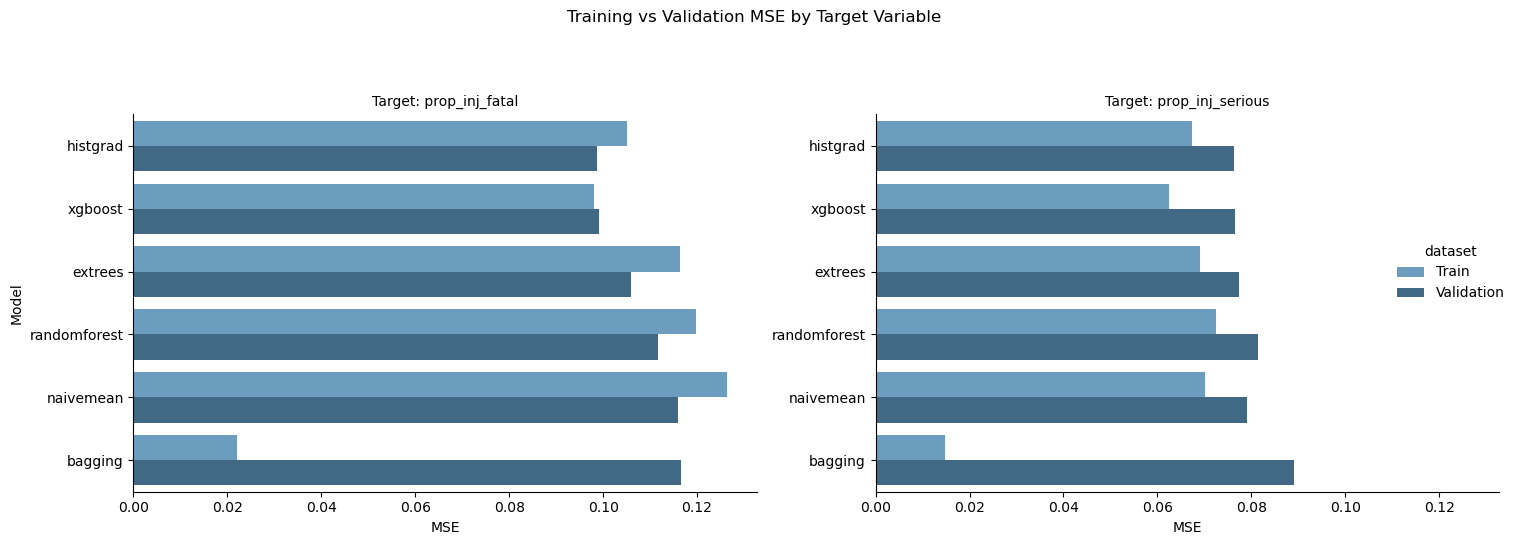

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only for MSE columns
df_filtered = performances.copy()

# Melt only MSE columns
mse_plot_df = df_filtered.melt(
    id_vars=['learner', 'target'],
    value_vars=['train_mse', 'val_mse'],
    var_name='metric',
    value_name='score'
)

# Extract 'Train' or 'Validation' from metric
mse_plot_df['dataset'] = mse_plot_df['metric'].apply(lambda x: 'Train' if 'train' in x else 'Validation')

# Sort learners by average score across all targets/datasets
val_only = mse_plot_df[mse_plot_df['dataset'] == 'Validation']
sorted_order = (
    val_only.groupby('learner')['score']
    .mean()
    .sort_values()
    .index
    .tolist()
)

# Plot
g = sns.catplot(
    data=mse_plot_df,
    kind='bar',
    y='learner',
    x='score',
    hue='dataset',
    col='target',
    palette='Blues_d',
    height=5,
    aspect=1.4,
    sharey=False,
    order=sorted_order
)

g.set_titles("Target: {col_name}")
g.set_axis_labels("MSE", "Model")
g.fig.suptitle("Training vs Validation MSE by Target Variable", y=1.08)

plt.tight_layout()
plt.show()



In [81]:
# Read in Test Data
test = pd.read_csv('../data/ntsb_processed/ntsb_test_cleaned.csv').dropna()

y_test_f = np.ravel(test[target_f])
y_test_s = np.ravel(test[target_s])
X_test = test[features]

In [82]:
performances.min()

learner                                                  bagging
hyperparams    {'colsample_bytree': 0.6, 'learning_rate': 0.1...
target                                            prop_inj_fatal
train_mse                                               0.014267
train_mae                                               0.060705
val_mse                                                 0.076285
val_mae                                                 0.161061
dtype: object

In [83]:
print(performances[performances['val_mse'] == performances['val_mse'].min()])

    learner                                        hyperparams  \
7  histgrad  {'learning_rate': 0.05, 'max_iter': 100, 'max_...   

             target  train_mse  train_mae   val_mse   val_mae  
7  prop_inj_serious   0.067322   0.154759  0.076285  0.163823  


In [84]:
xgb_mod_f.feature_importances_

array([0.01499793, 0.01556197, 0.03084338, 0.01256411, 0.01320582,
       0.02068548, 0.02222161, 0.04401951, 0.01057028, 0.04137239,
       0.02005144, 0.01401913, 0.12812623, 0.01665443, 0.07962841,
       0.03801616, 0.02312627, 0.01495488, 0.01343103, 0.01770614,
       0.0038011 , 0.01180018, 0.02929015, 0.01597237, 0.01000349,
       0.01190768, 0.01078586, 0.01342334, 0.01908315, 0.01270744,
       0.        , 0.01966554, 0.01868493, 0.00982989, 0.01602245,
       0.00820104, 0.03939793, 0.03004005, 0.00676335, 0.01200523,
       0.00954106, 0.03003209, 0.03484289, 0.0148307 , 0.01091031,
       0.0087012 ], dtype=float32)